In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import sys
sys.path.insert(0, "../func_py/")
import infer_gbm as gbm
import data_utils as dtu

import warnings
warnings.filterwarnings("ignore")

In [2]:
metadata = pd.read_csv('metadata/metadata.tsv', sep='\t', index_col=0)

# List containing the 3 inference settings. Each element is composed by:
# - setting label patinet-ntimepoints
# - list of samples used in the inference
# - delta times that separate the samples in years
# - parameters of the gamma import function
pairs_and_dts = [
    ('AT', ('AT_t1_mem', 'AT_t2_mem', 'AT_t3_mem'), [1/12, 11/12], [5,4]),
    ('IM', ('IM_t1_mem', 'IM_t2_mem', 'IM_t3_mem'), [1/12, 11/12], [5,4]),
    ('IZ', ('IZ_t1_mem', 'IZ_t2_mem', 'IZ_t3_mem'), [1/12, 11/12], [5,4]),
]

In [3]:
label, samples, dtimes, priors = pairs_and_dts[2]

sp_counts = dtu.import_and_build_sparse_counts(samples, 'family', 'count')

# Importing also the noise parameters of the negative binomial
a_negbin = dtu.read_noise_negbin_a('inference/noise/', samples)
a_negbin

count label not found, setting the counts to 1
count label not found, setting the counts to 1
count label not found, setting the counts to 1
one or more samples do not have a lerned model, the parameter is set as the average of the others


array([0.16749305, 0.17910576, 0.15588035])

### Scanning the best likelihood at best tau and theta for different M_tot and n0s

It scans the best tau-alpha LL varying the boundary parameters n_0, M to check where we have a minimum valley. It is likely that we cannot really find the minimum because for large tau the LL is flat, but this gives me the right region of n0-M

In [10]:
pars = {
    'n_eval' : 3 * 10**5,
    'bounds00' : 0.8,
    'bounds01' : 80.0,
    'bounds10' : 1.0,
    'bounds11' : 2.0,
    'gamma_priors0' : priors[0],
    'gamma_priors1' : priors[1],
    'noise' : 1e-2,
    'lenght_scales0' : 10.,
    'lenght_scales1' : 1.,
    'xi' : 2e-4,
    'n_calls' : 10,
    'n_jobs' : 3,
    'log' : True
}
pd.Series(pars).to_csv('inference/gbm/pars_pat'+label+'_nmin1.tsv', sep='\t')
pref = 'inference/gbm/results_'
post = '_pat'+label+'_nmin1_1.tsv'

# Values of M and n0
n0s = np.logspace(np.log10(5), 3, 10)
M_tots = np.logspace(5.5, 9, 12, dtype=int)
R = 1
lls = np.zeros((len(n0s), len(M_tots), R)) 
taus = np.zeros((len(n0s), len(M_tots), R))
thetas = np.zeros((len(n0s), len(M_tots), R))

In [9]:
progress = tqdm(total=len(n0s)*len(M_tots)*R)
for i, n0 in enumerate(n0s):
    for j, M_tot in enumerate(M_tots):
        for k in range(R):
            prs = [pars['gamma_priors0'], pars['gamma_priors1']]
            infer_pars = gbm.gbm_infer_pars(dtimes, M_tot, n0, 1, pars['n_eval'], prs)
            bounds = [(pars['bounds00'], pars['bounds01']), (pars['bounds10'], pars['bounds11'])]
            ls = [pars['lenght_scales0'], pars['lenght_scales1']]
            res = gbm.learn_gbm_gp(sp_counts, infer_pars, bounds=bounds, n_calls=pars['n_calls'], \
                                   noise=pars['noise'], lenght_scales=ls, xi=pars['xi'], n_jobs=pars['n_jobs'])
            lls[i,j,k] = -res.fun
            taus[i,j,k] = res.x[0]
            thetas[i,j,k] = res.x[1]*res.x[0] / 2.0
            progress.update(1)
            
# Saving the results
frame_ll = dtu.update_result_frame(pd.DataFrame(), np.log10(n0s), np.log10(M_tots), lls)
frame_tau = dtu.update_result_frame(pd.DataFrame(), np.log10(n0s), np.log10(M_tots), taus)
frame_theta = dtu.update_result_frame(pd.DataFrame(), np.log10(n0s), np.log10(M_tots), thetas)
frame_ll.to_csv(pref + 'll' + post, sep='\t')
frame_tau.to_csv(pref + 'tau' + post, sep='\t')
frame_theta.to_csv(pref + 'theta' + post, sep='\t')

  0%|          | 0/4 [00:00<?, ?it/s]

In [11]:
# Reading the results and parameters
frame_ll = pd.read_csv(pref + 'll' + post, sep='\t', index_col=0)
frame_tau = pd.read_csv(pref + 'tau' + post, sep='\t', index_col=0)
frame_theta = pd.read_csv(pref + 'theta' + post, sep='\t', index_col=0)
pars = pd.read_csv('inference/gbm/pars_pat'+label+'_nmin1.tsv', sep='\t', index_col=0).to_dict()['0']

In [12]:
count_ll, mean_ll, std_ll, x, y = dtu.read_result_frame(frame_ll)
count_tau, mean_tau, std_tau, x, y = dtu.read_result_frame(frame_tau)
count_theta, mean_theta, std_theta, x, y = dtu.read_result_frame(frame_theta)

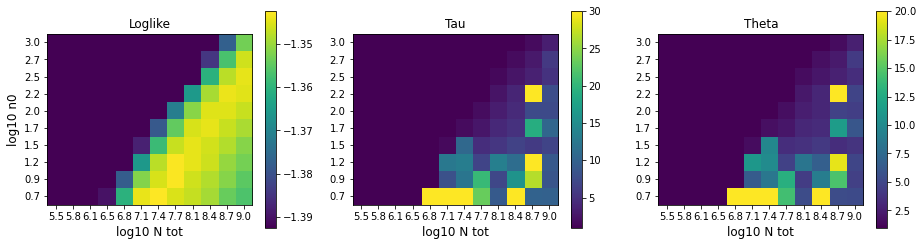

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,3.5))

ax1.set_title('Loglike', fontsize=12)
gbm.plot_heatmap(ax1, mean_ll, x, y, np.max(mean_ll) - 0.05, np.max(mean_ll), laby='log10 n0', labx='log10 N tot')

ax2.set_title('Tau', fontsize=12)
gbm.plot_heatmap(ax2, mean_tau, x, y, 1, 30, laby='', labx='log10 N tot')

ax3.set_title('Theta', fontsize=12)
gbm.plot_heatmap(ax3, mean_theta, x, y, 1, 20, laby='', labx='log10 N tot')

plt.tight_layout()
#plt.savefig('plots/gbm/ll_at_Mtot_n0_pat'+label+'_nmin1.svg')

### Fitting the ridge of maximum lileihood

[ 1.25825832 -8.67507257] [-6.515]


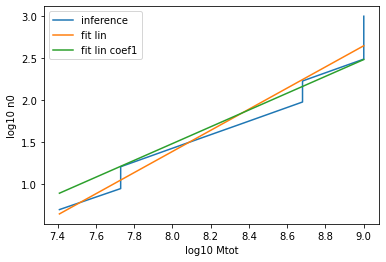

In [14]:
from scipy.optimize import curve_fit

def lin(x, a, b):
    return a * x + b

def lin_1(x, b):
    return x + b

M_tot_max = x[np.argmax(mean_ll, axis=1)]
max_n0_i = len(y) - 0
par_fit, cov = curve_fit(lin, M_tot_max[:max_n0_i], y[:max_n0_i])
par_fit_1, cov1 = curve_fit(lin_1, M_tot_max[:max_n0_i], y[:max_n0_i])
print(par_fit, par_fit_1)

plt.xlabel('log10 Mtot')
plt.ylabel('log10 n0')
plt.plot(M_tot_max[:max_n0_i], y[:max_n0_i], label='inference')
y_fit = lin(M_tot_max, par_fit[0], par_fit[1])
plt.plot(M_tot_max, y_fit, label='fit lin')
y_fit = lin_1(M_tot_max, par_fit_1[0])

ratio = 10**(-par_fit_1[0])
plt.plot(M_tot_max, y_fit, label='fit lin coef1')
plt.legend()

### Writing the parameters related to the ridge and not tau and alpha

Below we show that tau cannot be learned, but we can only find a lower boundary

In [ ]:
def write_on_file(path):
    f = open(path, 'w')
    f.write('n_points:\t' + str(pars['n_eval']) + str('\n'))
    f.write('logM_logn0_slope:\t' + str(par_fit[0]) + str('\n'))
    f.write('logM_logn0_offset:\t' + str(par_fit[1]) + str('\n'))
    f.write('logM_logn0_offset_slope1:\t' + str(par_fit_1[0]) + str('\n'))
    f.write('plateau_rank:\t' + str(rank_plateau) + str('\n'))
    m_ll = mean_ll.flatten()[np.argsort(mean_ll.flatten())[::-1][:rank_plateau]].mean()
    #f.write('mean_ll:\t' + str(m_ll) + str('\n'))
    #f.write('tau:\t' + str(av_taus_at_ll_rank[rank_plateau]) + str('\n'))
    #f.write('theta:\t' + str(av_theta_at_ll_rank[rank_plateau]) + str('\n'))
    #f.write('tau_err:\t' + str(std_taus_at_ll_rank[rank_plateau]) + str('\n'))
    #f.write('theta_err:\t' + str(std_theta_at_ll_rank[rank_plateau]) + str('\n'))
    #f.write('birth_rate:\t' + str(birth_rate) + str('\n'))
    f.write('n0:\t' + str(10**(11 + par_fit_1[0])) + str('\n'))
    f.close()
    
write_on_file('inference/gbm/pat'+label+'_nmin1.txt')

### Checking the log-likelihood shape at best alpha varying tau

We'll find that after a given value, the likelihood stays flat.
This fixes a lower bound for tau but not a single best value.
Differently, for all the range of flat tau, alpha is constant, giving us a precise value.

In [15]:
# Finding the value of n0 by assuming M total memory cells
pars = dtu.read_pars('inference/gbm/pat'+label+'_nmin1.txt')
M_tot = 10**8
n0 = 10**(lin(np.log10(M_tot), pars['logM_logn0_slope'], pars['logM_logn0_offset']))
print(n0)

24.60333456043409


In [ ]:
infer_pars = gbm.gbm_infer_pars(dtimes, M_tot, n0, 1, 3*10**5, priors, a_negbin)
taus = np.logspace(0, 2, 40)

lls, alphas = np.zeros(len(taus)), np.zeros(len(taus))
progress = tqdm(total=len(taus))
for i, t in enumerate(taus):
    # Inference of the best alpha at fixed tau
    res = gbm.learn_gbm_gp_alpha(sp_counts, t, infer_pars, n_calls=50, bounds=[(0.8, 2.0)], n_jobs=4)
    lls[i] = -res.fun
    alphas[i] = res.x[0]
    progress.update(1)
    
# Writing the results
path = 'inference/gbm/ll_vs_tau_pat'+label+'_nmin1.tsv'
pd.DataFrame(np.array([taus, lls, alphas]).T, columns=['tau', 'loglike', 'best_alpha']).to_csv(path, sep='\t')

In [16]:
path = 'inference/gbm/ll_vs_tau_pat'+label+'_nmin1.tsv'
fr = pd.read_csv(path, sep='\t', index_col=0)

In [19]:
def piecewise_exp_const_vec(xs, a_exp, b_exp, c_const, x_th):
    f_exp = a_exp * (np.exp(-b_exp * xs) - np.exp(-b_exp * x_th)) + c_const
    return np.where(xs < x_th, f_exp, c_const)
    
p_fit, cov = curve_fit(piecewise_exp_const_vec, fr.tau, -fr.loglike, bounds=[(0.005, 0.1, 1.3, 3), (0.05, 2, 1.6, 25)])
p_fit

array([ 0.0427928 ,  0.79045649,  1.40742427, 24.99998786])

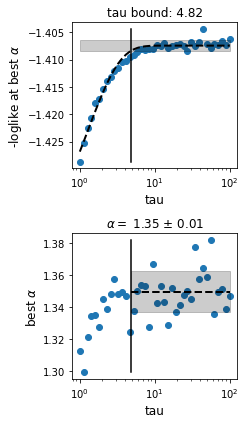

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(3.5,6))

xs, ys = fr.tau.values, -fr.loglike.values
std_const = np.std(ys[xs > p_fit[3]])
x_bound = - np.log(std_const / p_fit[0] + np.exp(-p_fit[1] * p_fit[3])) / p_fit[1]

ax1.set_title('tau bound: %3.2f'%x_bound)
ax1.set_xlabel('tau', fontsize=12)
ax1.set_ylabel(r'-loglike at best $\alpha$', fontsize=12)
ax1.set_xscale('log')

ax1.scatter(xs, -ys)
ax1.plot(xs, -piecewise_exp_const_vec(xs, p_fit[0], p_fit[1], p_fit[2], p_fit[3]), c='k', ls='--', lw=2)
y_const = np.ones(len(xs))*p_fit[2]
ax1.fill_between(xs, -y_const-std_const, -y_const+std_const, color='k', alpha=0.2)
ax1.plot([x_bound, x_bound], [-min(ys), -max(ys)], color='k')


alphs = fr.best_alpha.values
av_alpha = np.mean(alphs[xs > x_bound])
std_alpha = np.std(alphs[xs > x_bound])
xs_aux = np.array([x_bound, xs[-1]])
ys_aux = np.array([av_alpha, av_alpha])

ax2.set_title(r'$\alpha = $ %3.2f $\pm$ %3.2f'%(av_alpha, std_alpha))
ax2.set_xscale('log')
ax2.set_xlabel('tau', fontsize=12)
ax2.set_ylabel(r'best $\alpha$', fontsize=12)

ax2.scatter(xs, alphs)
ax2.plot(xs_aux, ys_aux, c='k', ls='--', lw=2)
ax2.fill_between(xs_aux, ys_aux-std_alpha, ys_aux+std_alpha, color='k', alpha=0.2)
ax2.plot([x_bound, x_bound], [min(alphs), max(alphs)], color='k')

plt.tight_layout()
#plt.savefig('plots/gbm/ll_at_best_alpha_pat' + label + '.svg')

### Updating the inference parameters with the lower boudare and alpha computed in the new way

In [31]:
pars['tau_low_bound'] = x_bound
pars['average_alpha'] = av_alpha
pars['std_alpha'] = std_alpha
pars['birth_rate_bound'] = gbm.birth_rate(10**(-par_fit_1[0]), x_bound, av_alpha*x_bound/2.0)
pars['N'] = (av_alpha - 1) / av_alpha * ratio * np.log(pars['n0'])
pd.Series(pars).to_csv('inference/gbm/pat'+label+'_nmin1_2.txt', sep='\t', header=None)